# Reading the data 

---

Lately, the _.fits_ data was transformed into _.csv_ and saved in database/csv_files. We are going to import a light curve sample and work with it.

In [1]:
FILE_PATH = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/csv_files/EN2_STAR_CHR_0101086161_20070516T060226_20071005T074409.csv'

In [2]:
import pandas as pd

data_sample = pd.read_csv(FILE_PATH)
display(data_sample)

,DATE,WHITEFLUX
0,2007-05-16 18:10:55.071642,112626.77
1,2007-05-16 18:19:27.113766,112605.61
2,2007-05-16 18:27:59.155929,112771.50
3,2007-05-16 18:36:31.198092,113113.60
4,2007-05-16 18:45:03.240256,112621.79
...,...,...
23946,2007-10-05 19:08:02.358665,112438.61
23947,2007-10-05 19:16:34.313684,112406.01
23948,2007-10-05 19:25:06.268742,112496.13
23949,2007-10-05 19:33:38.223801,112344.83


In [3]:
import numpy as np

x = data_sample.DATE.to_numpy()
y = data_sample.WHITEFLUX.to_numpy()

# Frequency Domain Filtering Fundamentals

---

## Introduction
Filtering in the frequency domain consists of modifying the Fourier transform of an signal (can be a image, a media file, a light curve...) and then taking the inverse tranform to obtained the filtered result. Thus, given a digital signal, $f(x)$, of length $M$, the basic filtering equation is: 

$$
g(x) = \mathcal{F}^{-1}[H(u)F(u)] \\
$$

where $\mathcal{F}^{-1}$ is the Inverse discrete Fourier transform, $F(u)$ is the Fourier transform of the given function $f(x)$ (input), $H(u)$ is the _filter transfer function_, and $g(x)$ is the filtered signal (output). Both $F$, $H$ and $G$ are arrays of size $M$, the same as the input signal. The product $H(u)F(u)$ is formed using array multiplication; that is, $G(i, k)=H(i, k)F(i, k)$.

## Expand LightCurves borders

To perform the filtering of the light curves in this work, we will use the Fast Fourier Transform (FFT) algorithm in  order to convert the signal in its original domain in the frequency domain. The choice of FFT is simple, this algorithm has complexity of $O(N log\ N)$, while the Discrete-time Fourier transform has complexity $O(N^2)$, where $N$ is the input data size, it means, FFT is much more computationally efficient.


However, the FFT has some peculiarities that can lead to problemas and unexpected results. The algorithm is based on the sucessive folding method [Gonzales and Woods, 1992], in other words, it assumes that the input signal is periodic and that the number of samples is an integer and a power of 2, but the 
second premise is not a requirement general. The first conjecture is quite relevant to not having distortion in the algorithm outout although. Colleting $M$ samples of a signal, which CoRoT did for us, is equivalent to cutting a 
finite piece of the real signal, i.e., we take a window between $T_1$ and $T_2$ of a defined signal of ${-\infty}$ to ${+\infty}$. There is a possibility that this window perfectly represents the oscillations of the original signal,
that is contain complete periods of all frequencies, thus we will have a FFT without distortions, but it is statistically unlikely that this will happen. In this case, we will have incomplete periods, which will introduce high frequency
distorcions in the signal that, in general, will be found at the ends of the signal.

 The reason that distorcions are commonly introduced at the ends of the signal is justified by the way FFT works. 
Their recursive calculations imply append the end of the signal with it's beginning (from the FFT's premise, we would
have a complete peridod), and it is at this conection that unexpected frequencies are introduced. So, to reduce this effect,
we will apply the method of expanding the signal edges. Given a sequence $A$, of size $k$, the method consists of adding
$N$ points before $A$'s first point, $A[0]$ and $N$ points after its last point, $A[-1]$. Finnaly, we will have a sequence
$B$, of size $(k + 2N)$.

In [4]:
def expand_borders(array, num):
  aux_pre = np.zeros(num)
  aux_pos = np.zeros(num)
  i = 0
  for i in range(num):
    aux_pre[i] = array[0]
    aux_pos[i] = array[-1]
  
  return np.concatenate((aux_pre, array, aux_pos)).ravel()

In `expand_borders` function, the parameter `num` means the number of points to be added at the beginning and at the end of the original signal.

In [5]:
n_points_expansion = 70

y_expanded = expand_borders(y, n_points_expansion)

print("The original length was:", len(y), ", and now we have:", len(y_expanded), "\nThe difference is:", (len(y_expanded) - len(y) ))

The original length was: 23951 , and now we have: 24091 
The difference is: 140


## Avoiding _wraparound_ error

The product $[H(u)F(u)]$, provided by the basis filtering equation, is obtained by the Array product. Consider the following 4x1 vectors:

$$
\begin{bmatrix}
  a_{1} & a_{2} & a_{3} & a_{4}
\end{bmatrix} \kern1em and \kern1em
\begin{bmatrix}
  b_{1} & b_{2} & b_{3} & b_{4}
\end{bmatrix} \\
$$


The Array product is defined by:

$$
\begin{bmatrix}
  a_{1} & a_{2} & a_{3} & a_{4}
\end{bmatrix}
\begin{bmatrix}
  b_{1} & b_{2} & b_{3} & b_{4}
\end{bmatrix} = 
\begin{bmatrix}
  a_{1}b_{1} & a_{2}b_{2} & a_{3}b_{3} & a_{4}b_{4}
\end{bmatrix} \\
$$

In mathematics, convolution is a linear operator of two functions ($f$ and $g$) that measures how the shape of one is modified by the other. The convolution of two functions involves rotating by 180° one about its origin and displacemening it past the other. In discrete functions, it is given by:

$$ (f*g)(k) = h(k) \triangleq \sum_{j=0}^{k}f(j) \cdot g(k-j)  $$

where $f$ and $g$ are arrays of size $n$.

The 1-D Convolution theorem, in the case of discrete convolution, tells us that:

$$ \mathcal{F}\{ f*g \} = k \cdot \mathcal{F}\{f\} \mathcal{F}\{g\}  $$

where $\mathcal{F}$ is the Fourier transform and $k$ is a constant.

Therefore, the Fourier transform of the convolution of two functions in spatial domain corresponds to the product of the transformations of these functions in the frequency domain. Writing in order to facilitate the relationship between ther Convolution theorem and the basic filtering equation, we have:

$$ f(t) * h(t)  \iff F(\mu)H(\mu) $$

The double arrow means that the expression on the right side is obtained by taking the Fourier transform of the expression on the left, as well as, the expression on the left was obtained by taking the inverse Fourier transform of the expression on the right.



---


Assim, se utilizar a DTF e o Teorema da convolução para obter o mesmo resultado de filtragem, devemos tomar conta a periodicidade implícita na expressão para a DFT. Nesse caso, estaríamos aplicando a convolução à duas funções teóricamente períodicas, o que implicaria no resultado da convolução ser também periódico que, por meio de aplicações práticas nota-se ser completamente errôneo. A proximidade dos períodos de ambas funções é tamanha que eles interferem um no outro, provocando o erro de _wraparound_ (efeito de borda). 

Já estamos minimizando esse erro realizando a expansão das extremidades do sinal, contudo essa prática pode não ser suficiente para lidar com o efeito de borda. Para tornar nosso algoritmo ainda mais robusto quanto ao erro de _wraparound_ e otimizar o cálculo da FFT, aplicaremos o Zero Padding

Esse procedimento consiste em adicionar zeros no final do sinal do dominío espacial, antes de ser calculada sua transformada de Fourier, visando aumentar o seu tamanho. Esse procedimento é utilizado para remover a periodicidade implícita do sinal, o que acarreta em resultados inesperados no resultado da filtragem. Tal propriedade matemática está deduzida na obra Fast Fourier Transform and Its Applications by E. Brigham (1988).

Outra grande utilidade do Zero Padding é em otimizar o algoritmo da FFT. Como, seguindo algumas regras, podemos modificar o tamanho no nosso sinal original, é uma boa prática transformar o seu tamanho em uma potência de 2. Para prosseguirmos com esse procedimento, temos que seguir algumas regras: [FFT Zero Padding](https://www.bitweenie.com/listings/fft-zero-padding/).



In [6]:
def padding(array):
  return np.append(array, np.zeros(len(array)))

In [7]:
y_padded = padding(y_expanded)

print("The previous length was:", len(y_expanded), ", and now we have:", len(y_padded), "\nThe difference is:", (len(y_padded) - len(y_expanded) ))

The previous length was: 24091 , and now we have: 48182 
The difference is: 24091


## Centering the transform

With Zero Padding applied, the next step is to try to simplift the definition of the filter transfer function, $H(u)$. Based on symmetry properties of funcions, it is noted that the specification of $H(u)$ is quite simplified when we are working with symmetric functions by their center, which requires that their Fourier transform $F(u)$ also be centralized.

The centralization is demostraded by the propert of translation and rotation of the Fourier transform:

$$ f(x) e^{j2\pi(u_0 x/M)} \iff F(u - u_0) \\ $$

That is, multiply $f(x)$ by the exponential shown shifts the origin of DFT to $u_0$. Taking $u_0 = M/2$, the exponential becomes $e^{j\pi x} = (-1)^{x}$, stricly because $x$ is an integer. So,

$$ f(x) (-1)^{x} \iff F(u - M/2) \\ $$

Therefore, the multiplication of the input signal $f(x)$ by $(-1)^{x}$ implies the displacement of the data so that $F(0)$ it in the center of the interval $[0, M-1]$, as we wanted.

This procedure must be done before computing the Fourier transform of $f(x)$ and it is useful to help in visualizing the filtering process and in optimizing the generation of the filter array, so it not mandatory to implement it.



In [8]:
def multiplying_by_minus_one_to_index(array):
  i = 0
  new_array = np.ones(len(array))

  for i in range(len(array)):
    new_array[i] = array[i] * ( (-1)**(i) )
  
  return new_array

In [9]:
y_centralized = multiplying_by_minus_one_to_index(y_padded)

## Taking the Fourier transform

In [10]:
def fourier_transform(array):
  fft = np.fft.fft(array)
  
  return fft

In [11]:
y_fft = fourier_transform(y_centralized)

## Butterworth transfer function

In [12]:
cutoff_freq = 0.2
order       = 2

In [13]:
def butterworth_array(array, fourier_transform, cutoff_freq, order):
  # Extrating information of the signal
  
  n_time = len(array)             # 
  D0 = cutoff_freq * n_time       # 
  xc = n_time                     # 

  # Creating the filter array

  len_filter = len(fourier_transform)         # 
  filter = np.zeros(len_filter)   #

  for i in range(len_filter):
    filter[i] = 1.0 / (1.0+(abs(i-(xc-1.0))/D0)**(2.0*order))

  return filter

### Applying filter

In [14]:
y_butter = butterworth_array(y, y_fft, cutoff_freq, order) * y_fft

## Inverse Fourier transform

In [15]:
def inverse_fourier_transform(array):
  ifft = np.fft.ifft(array)

  return ifft

In [16]:
y_ifft = np.real(inverse_fourier_transform(y_butter))

## Removing Zero-Padding

In [17]:
def no_padding(array):
  return array[:int(len(array)/2)]

In [18]:
y_no_padding = no_padding(y_ifft)

## Removing borders expanded

In [19]:
def remove_expanded_borders(array, param):
  aux = np.delete(array, np.s_[:param])
  removed = np.delete(aux, np.s_[-param:])

  return removed

In [20]:
y_no_expanded = remove_expanded_borders(y_no_padding, n_points_expansion)

## Re-multiplying data by $(-1)^{x}$

In [21]:
y_filtered = multiplying_by_minus_one_to_index(y_no_expanded)

## Results

In [22]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                           mode='lines',
                           name='Original Light Curve'))

fig.add_trace(go.Scatter(x=x, y=y_filtered,
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Light Curve before and after the Butterworth filter',
                   xaxis_title='Date',
                   yaxis_title='Whiteflux')

fig.show()

Output hidden; open in https://colab.research.google.com to view.

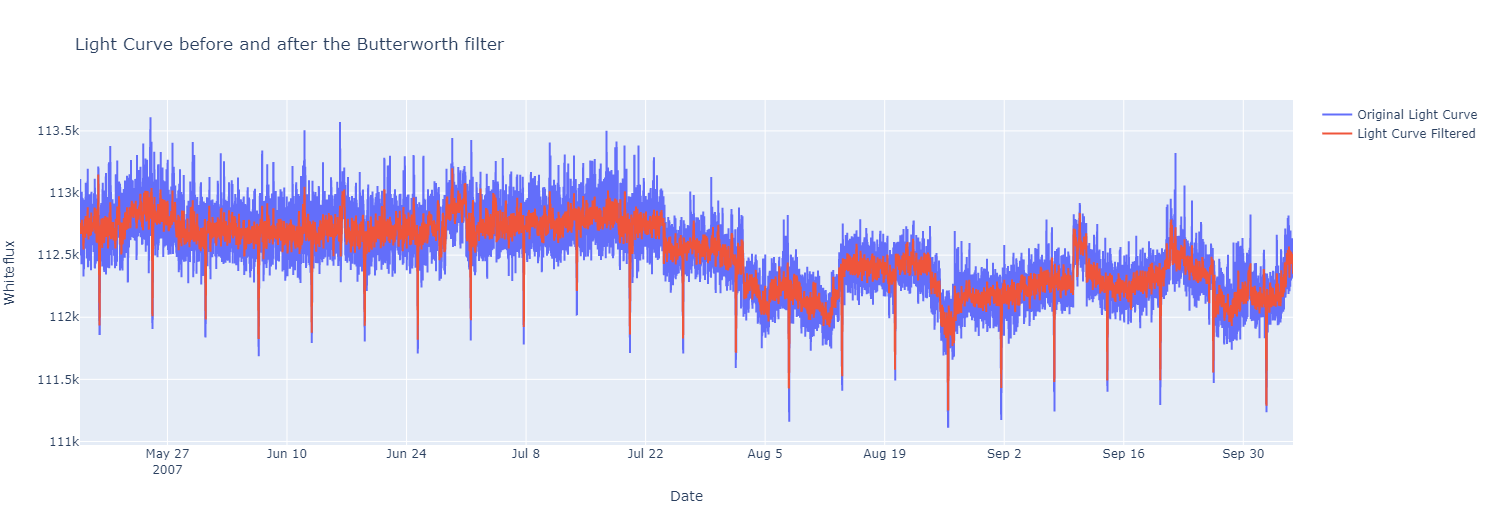

# Choosing the best filtering parameters

---

Since all the Mathematical and Computacional requirements have been prosecuted, we are going to summary all this on a single algorithm. On `filters` module, which belong to `tools` library, we have an object `FrequencyDomainFiltering` and it has the method `filter` that make all the signal pre-processing procedures, the filtering and the pos-processing. 

In [23]:
from tools import *

In [24]:
import matplotlib.pyplot as plt

## Keep filter order at 2

In [25]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.05, order=2)
y_filtered = Filter.getFiltered
viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.05')

Butterworth filtering


In [26]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.1, order=2)
y_filtered = Filter.getFiltered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.1')

Butterworth filtering


In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.2')

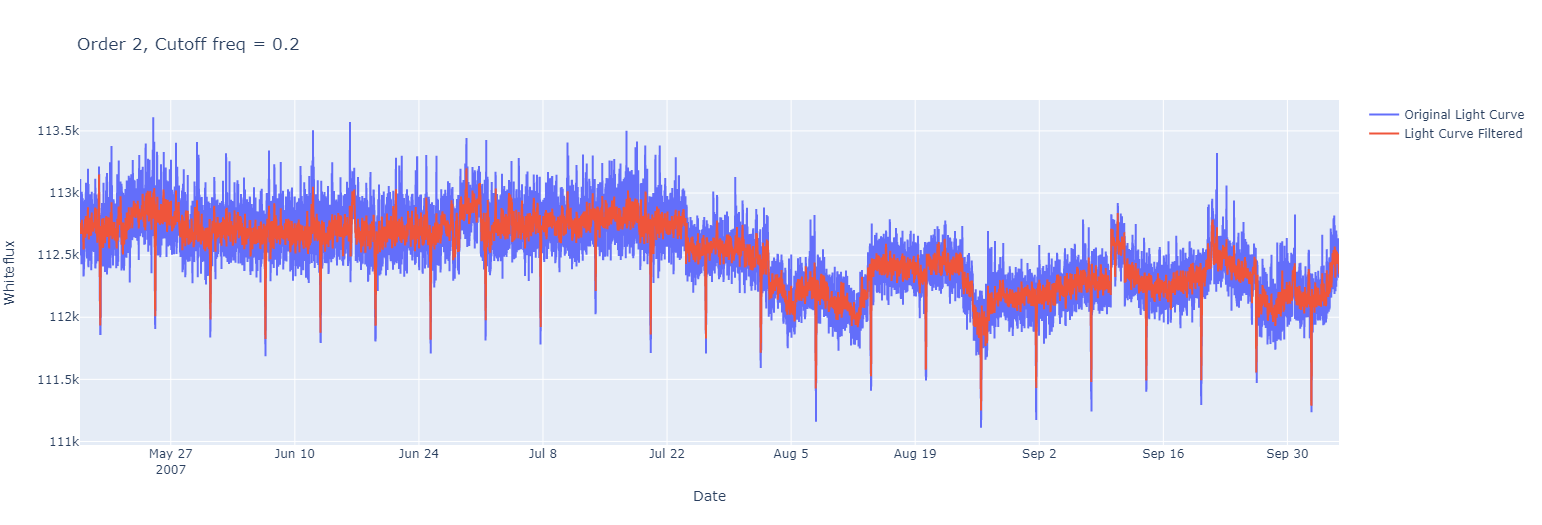

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.3, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.3')

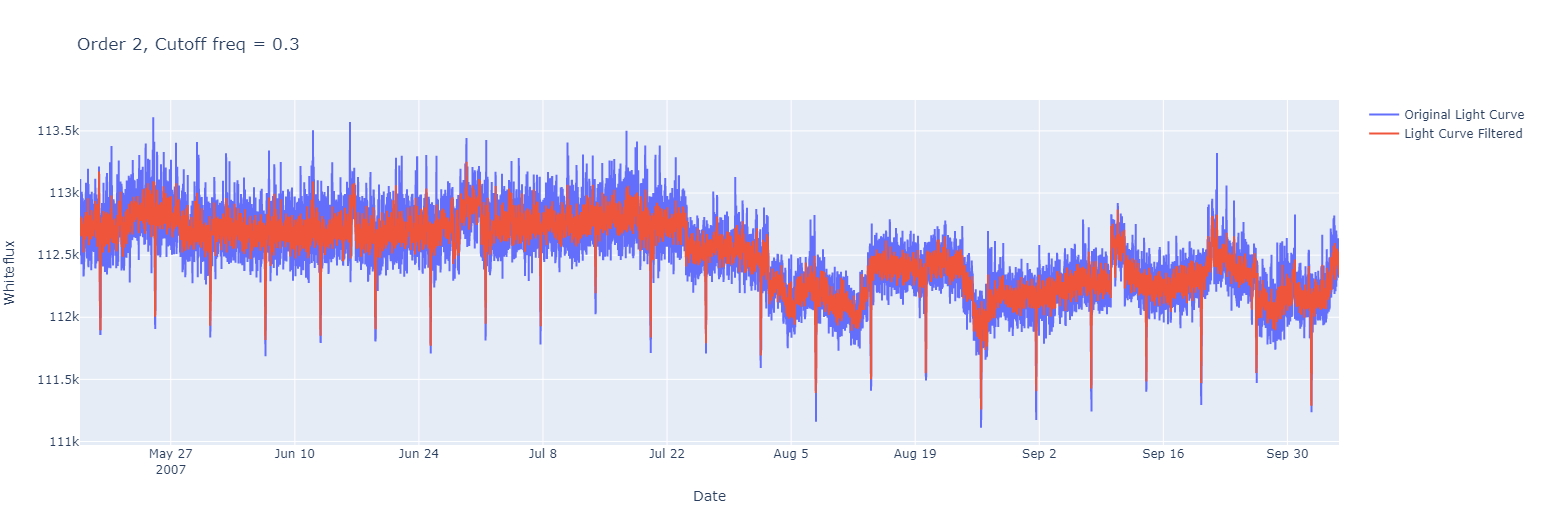

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.4, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.4')

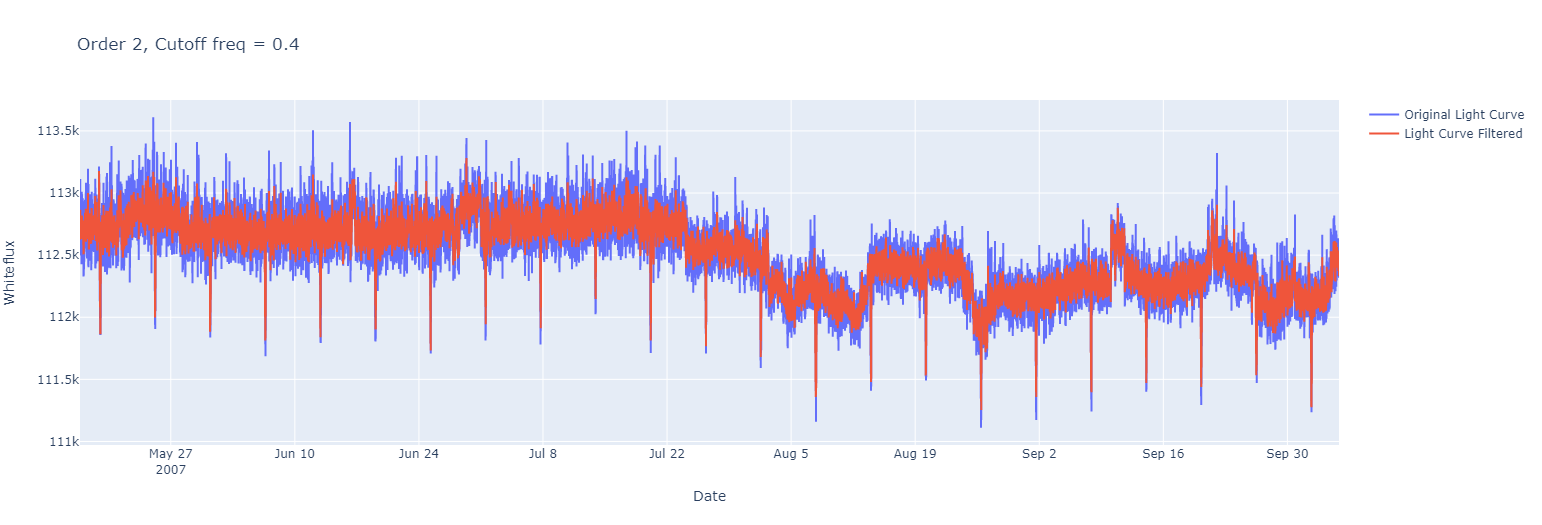

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.5, order=2)
y_filtered = Filter.filtered

viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.5')

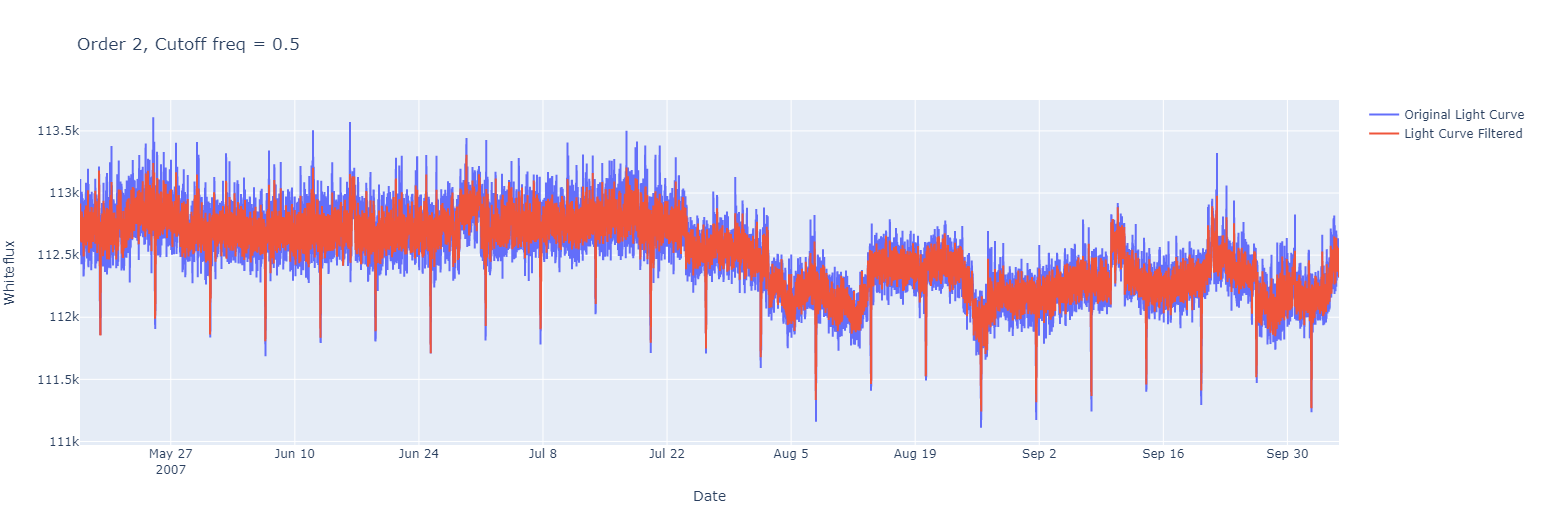

## Keep cutoff frequency at 0.2

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=2)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 2, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 2')

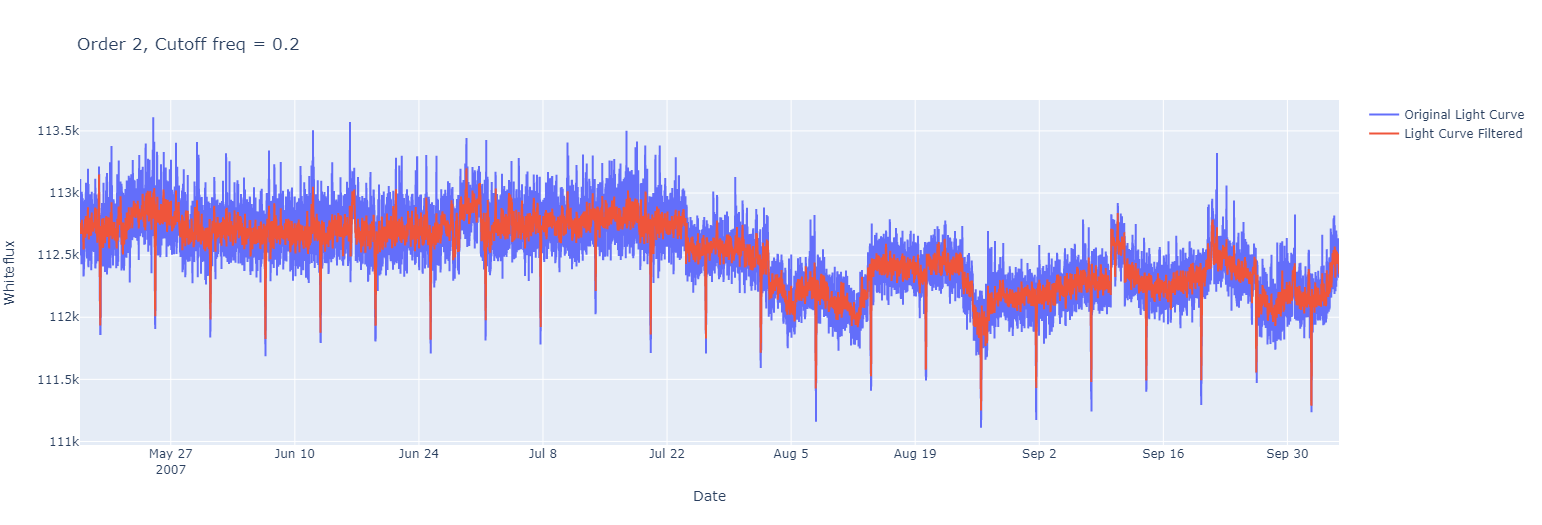

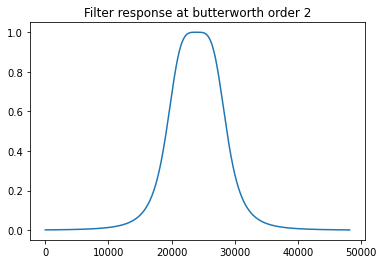

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=3)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 3, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 3')

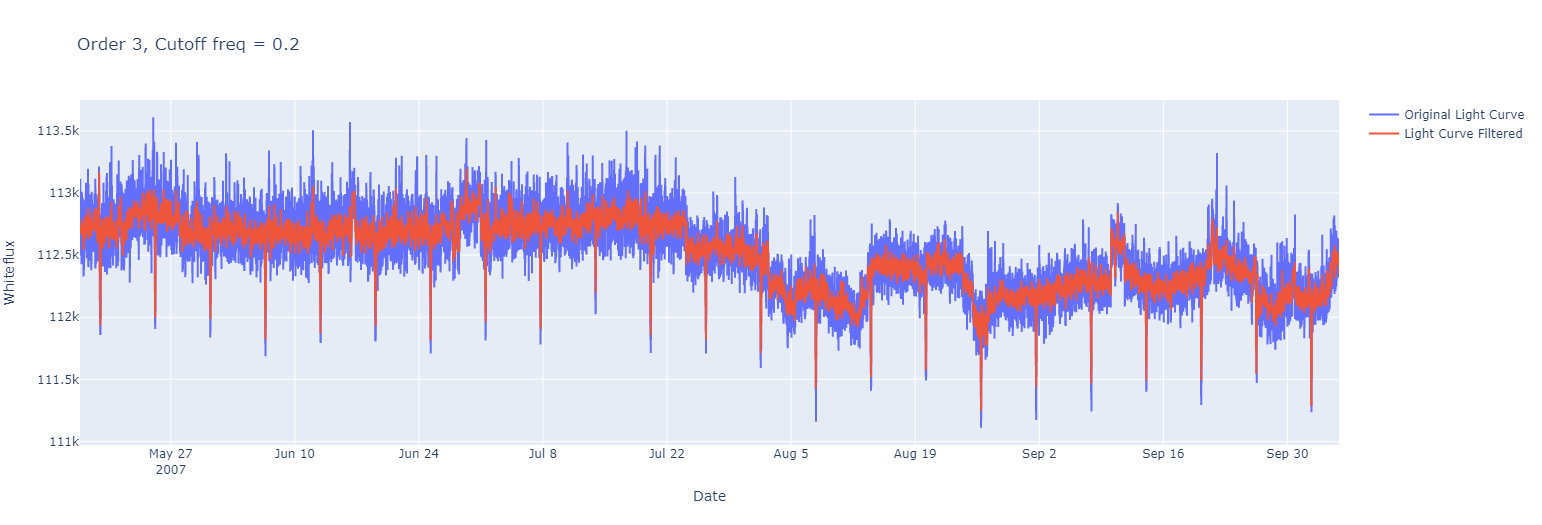

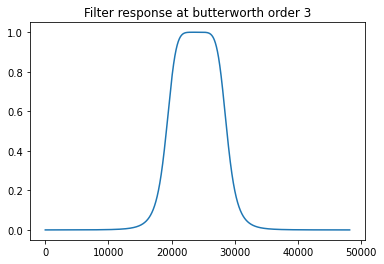

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=4)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 4, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 4')

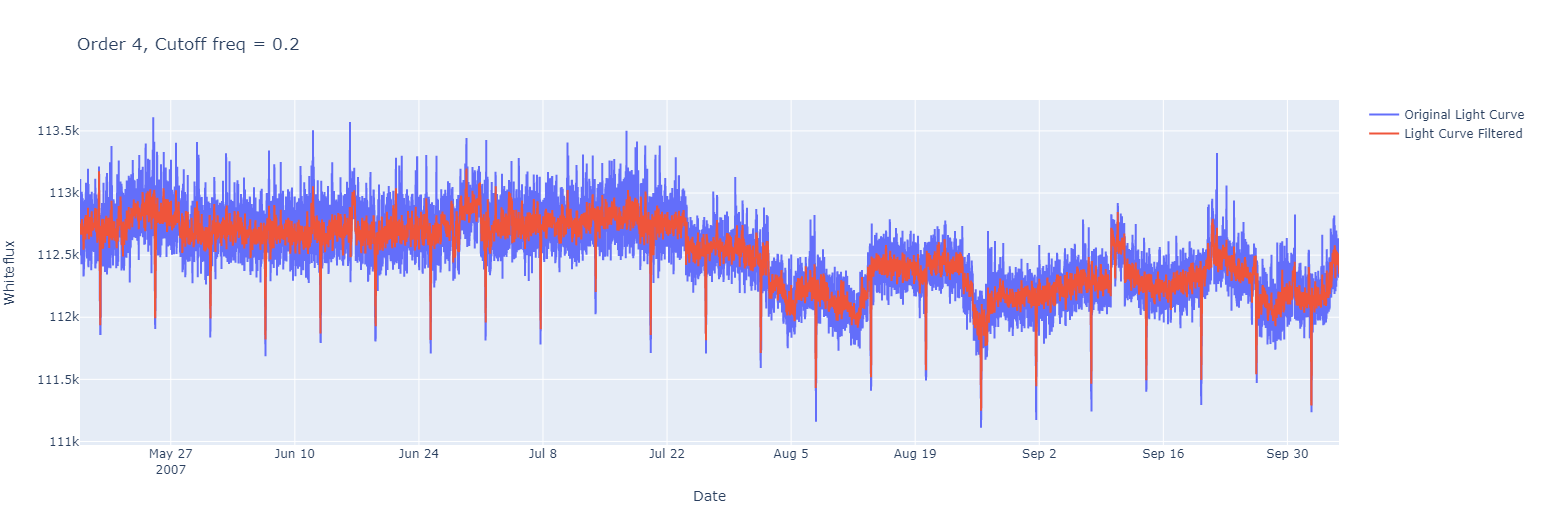

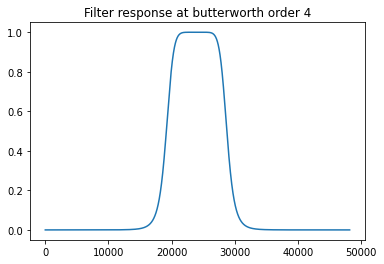

In [ ]:
Filter = filters.FrequencyDomainFiltering()

Filter.filter(array=y, filter='butterworth', numExpansion=70, cutoff_freq=0.2, order=5)
y_filtered = Filter.filtered
viz.view_filter_results(x, y, x, y_filtered, title='Order 5, Cutoff freq = 0.2')
plt.plot(Filter.filter_response)
plt.title('Filter response at butterworth order 5')

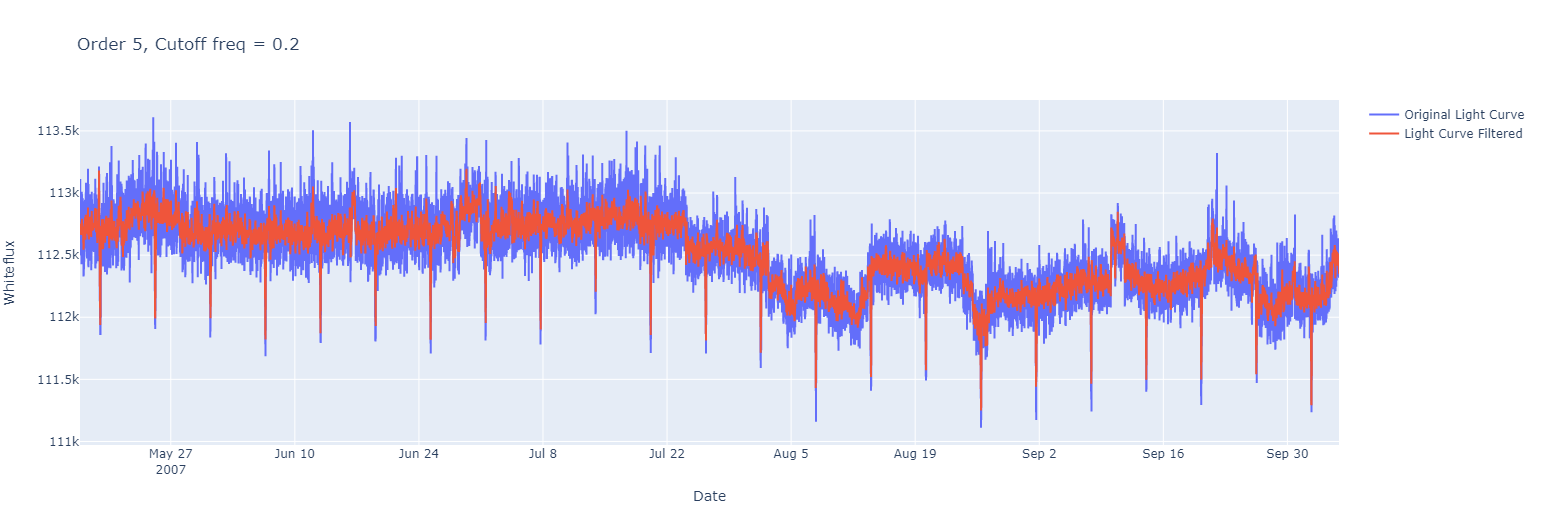

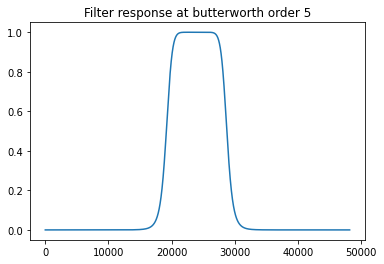